# Network construction

Network structure formulation in term of binary interaction matrix

In [1]:
# %load_ext autoreload
# %autoreload 2
import os
import sys
sys.path.insert(0, "./scripts")
import numpy as np
import pandas as pd
from itertools import combinations, product
import joblib
import functions as f

Actual parametrisation

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


## Random network for testing

In [3]:
cfg = f.update_cfg("./config.json", "TEST_NETWORK_LINK_PROB", 0.1, verbose=False)
cfg = f.update_cfg("./config.json", "TEST_NETWORK_SIZE", 500)

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: gs0.1


In [4]:
TEST_NETWORK_PATH = "./networks/test"

In [5]:
np.random.seed(cfg["RANDOM_SEED"])
network_size = cfg["TEST_NETWORK_SIZE"]
link_probability = cfg["TEST_NETWORK_LINK_PROB"]
interaction_matrix = np.random.binomial(
    1, link_probability, size=(network_size, network_size)
)

In [6]:
if not os.path.exists(TEST_NETWORK_PATH):
    os.mkdir(TEST_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(TEST_NETWORK_PATH, "interaction_matrix.gz"));

## Yeast Tnet

In [7]:
YEAST_NETWORK_PATH = "./networks/yeast"

In [8]:
edges = pd.read_csv("./raw_data/tfcomb/tnet.txt", sep="\t")
nodes = sorted(np.unique(np.concatenate((edges.Tf.unique(), edges.Tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	4441
Interactions number:	12873


,Tf,Tg
0,YAL051W,YAL016W
1,YAL051W,YAL034WA
2,YAL051W,YAL035CA
3,YAL051W,YAL035W
4,YAL051W,YAL036C


In [9]:
edges_ = edges.join(nodes, on="Tf").join(nodes, on="Tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

meta = tf_nodes, tf_only_nodes, tg_nodes, tg_only_nodes, tf_x_tg_nodes
joblib.dump(meta, os.path.join(YEAST_NETWORK_PATH, "meta.pkl"));

Total TF:	157
Total TG:	4410
TF and TG:	126
TG only:	4284
TF only:	31


In [10]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(YEAST_NETWORK_PATH):
    os.mkdir(YEAST_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(YEAST_NETWORK_PATH, "interaction_matrix.gz"));

## E. coli network

In [11]:
ECOLI_NETWORK_PATH = "./networks/ecoli"

In [12]:
df = f.read_ecoli_network("./raw_data/ecoli/network_tf_gene.txt")

In [13]:
edges = df[[1, 3]]
edges.columns = ["tf", "tg"]
edges.tf = edges.tf.apply(lambda x: x.lower())
edges.tg = edges.tg.apply(lambda x: x.lower())
nodes = sorted(np.unique(np.concatenate((edges.tf.unique(), edges.tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	1917
Interactions number:	4693


,tf,tg
0,accb,accb
1,accb,accc
2,acrr,acra
3,acrr,acrb
4,acrr,acrr


In [14]:
edges_ = edges.join(nodes, on="tf").join(nodes, on="tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

Total TF:	211
Total TG:	1854
TF and TG:	148
TG only:	1706
TF only:	63


In [15]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(ECOLI_NETWORK_PATH):
    os.mkdir(ECOLI_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(ECOLI_NETWORK_PATH, "interaction_matrix.gz"));

## Gene Spyder

### SNR 0.01

In [16]:
GS_NETWORK_PATH = "./networks/gs0.01"

interaction_matrix = pd.read_csv("./raw_data/GS_N800/N800_SNR_0.01.csv", header=None).astype(bool).astype(int).values
print(f"Total genes number:\t{interaction_matrix.shape[0]}")
interaction_matrix_adj = interaction_matrix - np.diag(np.diag(interaction_matrix))
print(f"Interactions number:\t{interaction_matrix_adj.sum()}")
print()
tg_idxs, tf_idxs = np.where(interaction_matrix_adj != 0)
print(f"Total TF:\t{np.unique(tf_idxs).shape[0]}")
print(f"Total TG:\t{np.unique(tg_idxs).shape[0]}")
print(f"TF and TG:\t{len(set(tg_idxs) & set(tf_idxs))}")
print(f"TG only:\t{len(set(tg_idxs) - set(tf_idxs))}")
print(f"TF only:\t{len(set(tf_idxs) - set(tg_idxs))}")

if not os.path.exists(GS_NETWORK_PATH):
    os.mkdir(GS_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(GS_NETWORK_PATH, "interaction_matrix.gz"));

Total genes number:	800
Interactions number:	1925

Total TF:	693
Total TG:	706
TF and TG:	604
TG only:	102
TF only:	89


### SNR 0.1

In [17]:
GS_NETWORK_PATH = "./networks/gs0.1"

interaction_matrix = pd.read_csv("./raw_data/GS_N800/N800_SNR_0.1.csv", header=None).astype(bool).astype(int).values
print(f"Total genes number:\t{interaction_matrix.shape[0]}")
interaction_matrix_adj = interaction_matrix - np.diag(np.diag(interaction_matrix))
print(f"Interactions number:\t{interaction_matrix_adj.sum()}")
print()
tg_idxs, tf_idxs = np.where(interaction_matrix_adj != 0)
print(f"Total TF:\t{np.unique(tf_idxs).shape[0]}")
print(f"Total TG:\t{np.unique(tg_idxs).shape[0]}")
print(f"TF and TG:\t{len(set(tg_idxs) & set(tf_idxs))}")
print(f"TG only:\t{len(set(tg_idxs) - set(tf_idxs))}")
print(f"TF only:\t{len(set(tf_idxs) - set(tg_idxs))}")

if not os.path.exists(GS_NETWORK_PATH):
    os.mkdir(GS_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(GS_NETWORK_PATH, "interaction_matrix.gz"));

Total genes number:	800
Interactions number:	1913

Total TF:	706
Total TG:	683
TF and TG:	594
TG only:	89
TF only:	112


In [18]:
GS_NETWORK_PATH = "./networks/gs1"

interaction_matrix = pd.read_csv("./raw_data/GS_N800/N800_SNR_1.csv", header=None).astype(bool).astype(int).values
print(f"Total genes number:\t{interaction_matrix.shape[0]}")
interaction_matrix_adj = interaction_matrix - np.diag(np.diag(interaction_matrix))
print(f"Interactions number:\t{interaction_matrix_adj.sum()}")
print()
tg_idxs, tf_idxs = np.where(interaction_matrix_adj != 0)
print(f"Total TF:\t{np.unique(tf_idxs).shape[0]}")
print(f"Total TG:\t{np.unique(tg_idxs).shape[0]}")
print(f"TF and TG:\t{len(set(tg_idxs) & set(tf_idxs))}")
print(f"TG only:\t{len(set(tg_idxs) - set(tf_idxs))}")
print(f"TF only:\t{len(set(tf_idxs) - set(tg_idxs))}")

if not os.path.exists(GS_NETWORK_PATH):
    os.mkdir(GS_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(GS_NETWORK_PATH, "interaction_matrix.gz"));

Total genes number:	800
Interactions number:	1929

Total TF:	692
Total TG:	716
TF and TG:	614
TG only:	102
TF only:	78


# Mouse

## TRRUST

In [3]:
cfg = f.get_actual_parametrization("config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [4]:
MOUSE_NETWORK_PATH = "./networks/mouse"

In [5]:
edges = pd.read_csv("./networks/mouse/trrust_rawdata.mouse.tsv", sep="\t", header=None)[[0, 1]]
edges.columns = ["Tf", "Tg"]
nodes = sorted(np.unique(np.concatenate((edges.Tf.unique(), edges.Tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	2456
Interactions number:	7057


,Tf,Tg
0,Aatf,Bak1
1,Aatf,Bax
2,Aatf,Bbc3
3,Aatf,Cdkn1a
4,Aatf,Tpt1


In [6]:
edges_ = edges.join(nodes, on="Tf").join(nodes, on="Tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

meta = tf_nodes, tf_only_nodes, tg_nodes, tg_only_nodes, tf_x_tg_nodes
joblib.dump(meta, os.path.join(MOUSE_NETWORK_PATH, "meta.pkl"));

Total TF:	827
Total TG:	2092
TF and TG:	463
TG only:	1629
TF only:	364


In [7]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(MOUSE_NETWORK_PATH):
    os.mkdir(MOUSE_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(MOUSE_NETWORK_PATH, "interaction_matrix.gz"));

In [8]:
interaction_matrix.shape, interaction_matrix.sum()

((2456, 2456), 6490.0)

In [9]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

CPU times: user 381 ms, sys: 71.7 ms, total: 453 ms
Wall time: 2.58 s


{'021C': 40969, '021D': 135077, '021U': 20789, '030C': 60, '030T': 1956}

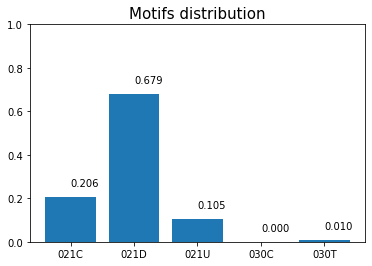

In [9]:
f.plot_motif_distr(counter)

Motif enrichment

In [14]:
from tqdm import tqdm
from matplotlib import pyplot as plt

In [12]:
noise_list = np.linspace(0, 80000, 11).astype(int)
score_list = []
for noise in tqdm(noise_list):
    shuffled_matrix = f.get_shuffled_matrix(interaction_matrix, noise)
    score_list.append(1-f.corruption_score(interaction_matrix, shuffled_matrix))

100%|██████████| 11/11 [00:34<00:00,  3.11s/it]


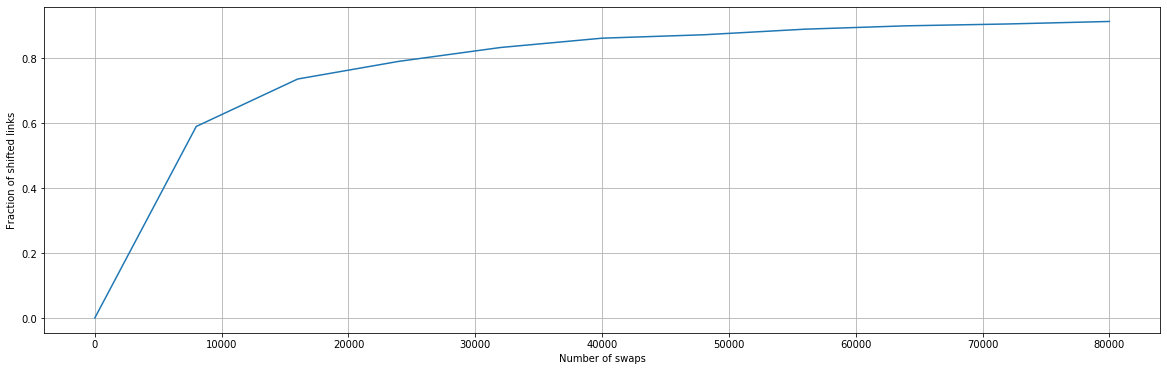

In [15]:
plt.figure(figsize=(20, 6))
plt.grid()
plt.ylabel("Fraction of shifted links")
plt.xlabel("Number of swaps")
plt.plot(noise_list, score_list);

In [3]:
interaction_matrix = joblib.load("./networks/mouse/interaction_matrix.gz")

In [4]:
interaction_matrix.shape, interaction_matrix.sum()

((2456, 2456), 6490.0)

In [5]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 40000
counters = f.generate_random_networks(cfg, interaction_matrix, N_SIMS, N_STEPS, N_SWAPS)

100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


In [6]:
joblib.dump(counters, "./networks/mouse/shuffled_counters.gz");

In [7]:
counters = joblib.load("./networks/mouse/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:04<00:00, 243.24it/s]


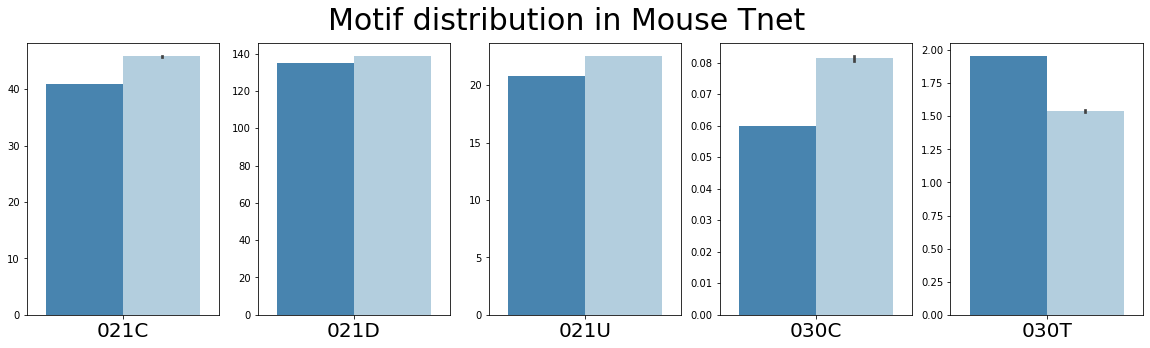

In [10]:
f.plot_distr(counters, counter, label="Motif distribution in Mouse Tnet", highlight=False);

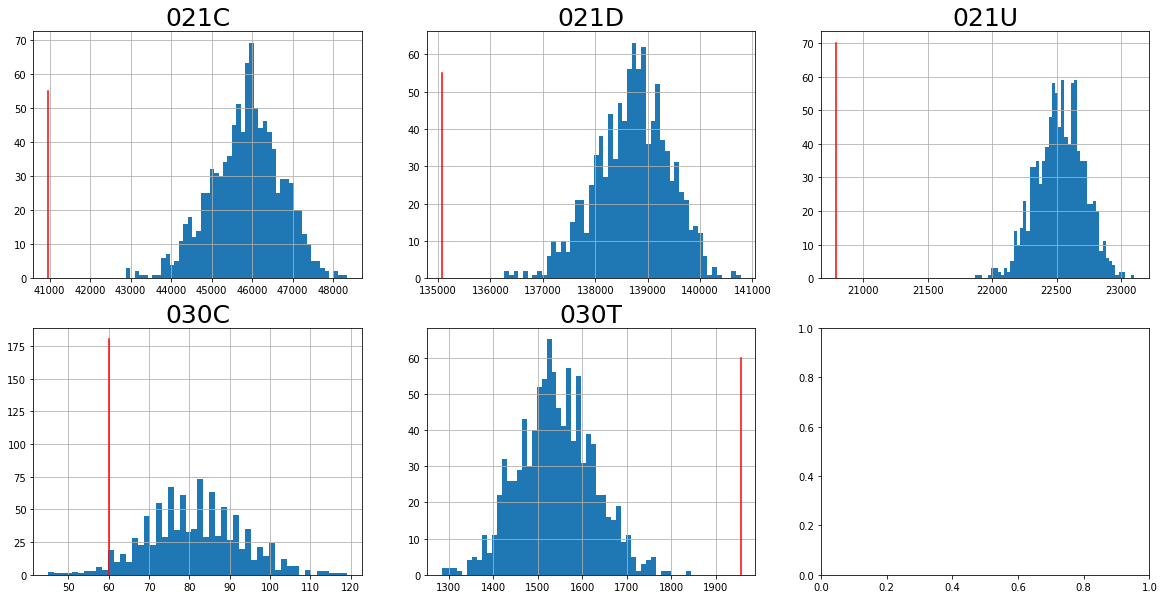

In [11]:
f.plot_distr_2(counters, counter, ticks = [55, 55, 70, 180, 60])

In [12]:
f.build_zscores_report(counters, counter)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,40969,45851.5,862.984,-5.65775,0,< 0.01
021D,135077,138709,698.981,-5.19599,0,< 0.01
021U,20789,22527.9,184.583,-9.42046,0,< 0.01
030C,60,81.372,11.6947,-1.8275,0.033,non-significant
030T,1956,1540.48,84.4663,4.91938,0,< 0.01
